In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  1 10:56:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    59W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
### Run this cell only if using Colab... ###
# Mount the Google Drive so we can access data
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.append('/content/drive/My Drive/CS7643_Project/Code/isaac/')

basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pip install piqa

In [5]:
import h5py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

from datetime import datetime
import os
import h5py

from piqa import SSIM

from unet_gan import *
from vgg_loss import *

# Set some variables

In [6]:
num_classes = 2  # Number of classes for the discriminator, which should be 2 since it's a binary classification problem
img_size = 300  # Number of pixels for h & w
batch_size = 16
lr = 0.0002  # Learning rate, in DCGAN paper it is 0.0002
ngpu = 1 # Number of GPUs
# Decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Get the data

## Training data

(4754, 300, 300)
(4754, 288, 288)
torch.Size([4754, 1, 288, 288])


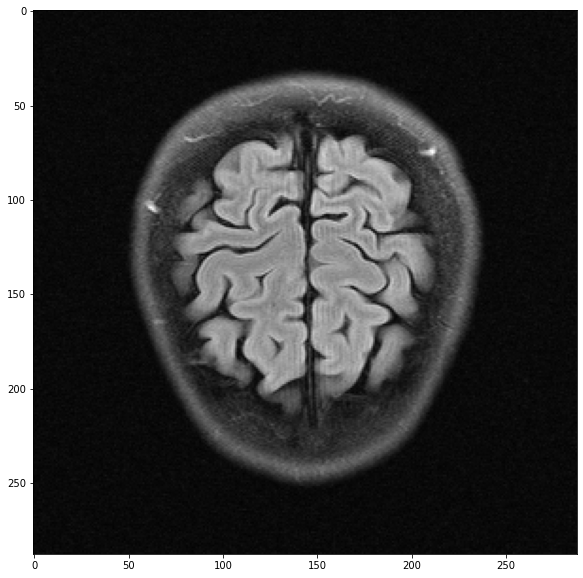

In [7]:
# Get the unsubsampled training data
hff = h5py.File(basefolder+'brain_AXFLAIR_full_TRAIN_1637456991.970846.h5', 'r')
train_full = np.array(hff['full_train'])
print(train_full.shape)

# Crop to 288 x 288 -- the Unet needs to have the image size in multiples of 32!!!
train_full = train_full[:,6:(300-6), 6:(300-6)]
print(train_full.shape)

# Show an example
#plt.imshow(train_full[2843], cmap='gray')
plt.imshow(train_full[10], cmap='gray')

# Make it a pytorch tensor
train_full = torch.from_numpy(train_full).unsqueeze(1)
print(train_full.shape)

(4754, 300, 300)
(4754, 288, 288)
torch.Size([4754, 1, 288, 288])


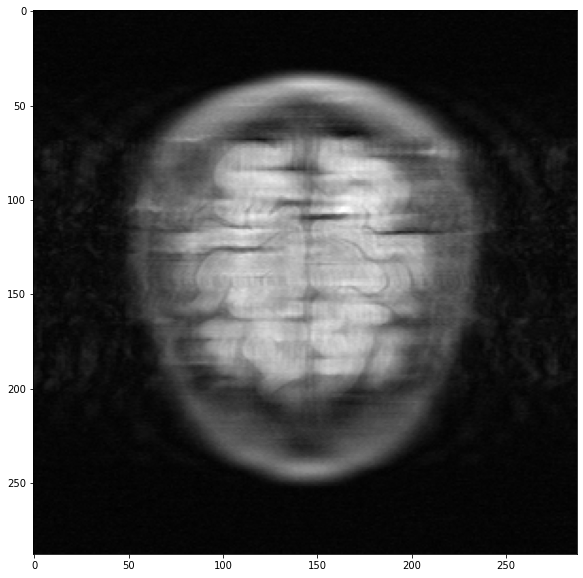

In [8]:
# Get the subsampled training data
hff = h5py.File(basefolder+'brain_AXFLAIR_subsampled_TRAIN_1637456991.970846.h5', 'r')
train_ss = np.array(hff['subsample_train'])
print(train_ss.shape)

# Crop to 288 x 288 -- the Unet needs to have the image size in multiples of 32!!!
train_ss = train_ss[:,6:(300-6), 6:(300-6)]
print(train_ss.shape)

# Show an example
#plt.imshow(train_ss[2843], cmap='gray')
plt.imshow(train_ss[10], cmap='gray')

# Make it a pytorch tensor
train_ss = torch.from_numpy(train_ss).unsqueeze(1)
print(train_ss.shape)

In [9]:
# Since we want to iterate over two datasets simultaneously (full and subsampled), we combine them into one (...for index, (xb1, xb2) in enumerate(dataloader):...)
print(train_full.shape)
print(train_ss.shape)
train_dataset = torch.utils.data.TensorDataset(train_full, train_ss)
dataloader1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Train datasets

torch.Size([4754, 1, 288, 288])
torch.Size([4754, 1, 288, 288])


## Validation data

In [10]:
# # Get the unsubsampled validation data
# hff = h5py.File(basefolder+'brain_AXFLAIR_full_VAL_1637484616.411167.h5', 'r')
# val_full = np.array(hff['full_val'])
# print(val_full.shape)

# # Crop to 288 x 288 -- the Unet needs to have the image size in multiples of 32!!!
# val_full = val_full[:,6:(300-6), 6:(300-6)]
# print(val_full.shape)

# # Show an example
# plt.imshow(val_full[10], cmap='gray')

# # Make it a pytorch tensor
# val_full = torch.from_numpy(val_full).unsqueeze(1)
# print(val_full.shape)

In [11]:
# # Get the subsampled validation data
# hff = h5py.File(basefolder+'brain_AXFLAIR_subsampled_VAL_1637484616.411167.h5', 'r')
# val_ss = np.array(hff['subsample_val'])
# print(val_ss.shape)

# # Crop to 288 x 288 -- the Unet needs to have the image size in multiples of 32!!!
# val_ss = val_ss[:,6:(300-6), 6:(300-6)]
# print(val_ss.shape)

# # Show an example
# plt.imshow(val_ss[10], cmap='gray')

# # Make it a pytorch tensor
# val_ss = torch.from_numpy(val_ss).unsqueeze(1)
# print(val_ss.shape)

In [12]:
# # Same with the validation data (full and subsampled), we combine them into one (...for index, (vf, vs) in enumerate(dataloader):...)
# # Since we want to iterate over two datasets simultaneously (full and subsampled), we combine them into one (...for index, (xb1, xb2) in enumerate(dataloader):...)
# val_dataset = torch.utils.data.TensorDataset(val_full, val_ss)
# dataloader2 = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Validation datasets

# Set up the models

In [13]:
# custom weights initialization called on netG and netD (per original DCGAN paper)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Feature extractor, we need this to compute content loss
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

In [15]:
# Discriminator
D = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
D.apply(weights_init)

print(device)
print(D)

cuda:0
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=82944, ou

In [16]:
# Generator
G = Generator(ngpu).to(device)
#G = Generator(ngpu).to('cpu')  # Debug for limited GPU memory

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
G.apply(weights_init)

print(device)
print(G)

cuda:0
Generator(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

Losses and Optimizers

In [17]:
# Wasserstein Loss
def wasserstein_loss(y_true, y_pred):
	return torch.mean(y_true * y_pred)

In [18]:
# Losses per the original super resolution paper
criterion_mse = torch.nn.MSELoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)

In [19]:
# FFT MSE Loss (per Yang, et al)
def fft_mse(y_true, y_pred):
  y_true_fft = torch.fft.fftn(y_true)
  y_pred_fft = torch.fft.fftn(y_pred)
  return criterion_mse(y_pred, y_true)

In [20]:
# setup SSIM loss
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

ssim_loss = SSIMLoss(n_channels=1).to(device)

In [21]:
# optimizers
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [22]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [23]:
# setup tensorboard writer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# Training loop
clip_value = 0.01 # For clipping the weights of the discriminator to enforce the Lipschitz constraint - see https://theaisummer.com/gan-computer-vision-incremental-training/

# save losses
d_losses = []
g_losses = []

for epoch in range(30):
  for index, (tf, ts) in enumerate(dataloader1):
    fully_sampled_images = tf.float().to(device)
    subsampled_images = ts.float().to(device)

    # Generate a high resolution image from low resolution input
    generated_samples = G(subsampled_images).to(device)

    real_samples_labels = torch.ones((fully_sampled_images.shape[0], 1)).to(device)
    generated_samples_labels = torch.zeros((fully_sampled_images.shape[0], 1)).to(device)
    all_samples = torch.cat((fully_sampled_images, generated_samples)).to(device)
    all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)).to(device)

    # ---------------------
    #  Train Discriminator
    # ---------------------
    D.zero_grad()

    discriminator_output = D(all_samples).to(device)

    d_loss = wasserstein_loss(discriminator_output, all_samples_labels)
    # d_loss = loss_function(discriminator_output, all_samples_labels)
    # d_loss = -torch.mean(D(fully_sampled_images)) + torch.mean(D(generated_samples.detach()))

    d_loss.backward(retain_graph=True)
    d_optimizer.step()

    # ---------------------
    #  Train Generator
    # ---------------------
    G.zero_grad()

    discriminator_output = D(generated_samples)

    g_loss = wasserstein_loss(discriminator_output, real_samples_labels)
    # g_loss = loss_function(discriminator_output, real_samples_labels)
    # g_loss = g_criterion(fake_images, fully_sampled_images)

    g_loss.backward()
    g_optimizer.step()

  # save losses
  d_losses.append(d_loss.item())
  g_losses.append(g_loss.item())

  ### print and save things ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # writer.add_scalar("d_loss_real", d_loss_real, epoch)
  # writer.add_scalar("d_loss_fake", d_loss_fake, epoch)
  writer.add_scalar("d_loss", d_loss, epoch)
  writer.add_scalar("g_loss", g_loss, epoch)

  # PyTorch has a function to save a batch of images to file
  # fake_images = fake_images.squeeze(1).to('cpu').detach().numpy()
  #save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

  ### After each epoch calculate the validation loss
  
writer.flush()

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

# Show subsampled, fake, and real images
plt.imshow(ts[0,0].cpu().detach().numpy(), cmap='gray')
plt.show()

# generated_image = fake_images[0].to('cpu').detach().numpy().squeeze()*255
generated_image = fake_images[0]*255
plt.imshow(generated_image, cmap='gray', filternorm=True, vmin=0.0, vmax=0.2)
plt.show()

plt.imshow(tf[0,0].cpu().detach().numpy(), cmap='gray')
plt.show()

Epoch: 0, d_loss: 2.979943047876077e-08, g_loss: 8.234426786657423e-05
Epoch: 1, d_loss: 1.4156391614505992e-08, g_loss: 5.150716788193677e-06
Epoch: 2, d_loss: 6.4087819495739495e-09, g_loss: 5.022139521315694e-05
Epoch: 3, d_loss: 8.72318572930908e-09, g_loss: 9.658160706749186e-07
Epoch: 4, d_loss: 3.870251674698011e-09, g_loss: 8.263264135166537e-07
Epoch: 5, d_loss: 9.55703072236247e-10, g_loss: 1.5668722426198656e-06
Epoch: 6, d_loss: 1.3802292642139946e-09, g_loss: 2.806791235343553e-05
Epoch: 7, d_loss: 4.3475165689699224e-09, g_loss: 2.795545128719823e-08
Epoch: 8, d_loss: 1.4212651056055847e-09, g_loss: 1.2060476706210466e-07
Epoch: 9, d_loss: 9.336991180219911e-10, g_loss: 3.346818999716561e-08
Epoch: 10, d_loss: 1.002603777777722e-09, g_loss: 1.5250769138219766e-05
Epoch: 11, d_loss: 9.235986420108588e-10, g_loss: 1.1677294509127023e-07
Epoch: 12, d_loss: 7.303188054308407e-10, g_loss: 2.1373391234646988e-07
Epoch: 13, d_loss: 2.1726717647219118e-10, g_loss: 2.1375555661506

In [ ]:
# run tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# close tensorboard writer
writer.close()

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [ ]:
# Show subsampled, fake, and real images
plt.imshow(ts[0,0].cpu().detach().numpy(), cmap='gray')
plt.show()

# generated_image = fake_images[0].to('cpu').detach().numpy().squeeze()*255
generated_image = fake_images[0]*255
plt.imshow(generated_image, cmap='gray')
plt.show()

plt.imshow(tf[0,0].cpu().detach().numpy(), cmap='gray')
plt.show()

In [ ]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/50.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/100.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/150.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/200.png')
plt.imshow(a)